### Resources
https://docs.dgl.ai/en/0.6.x/api/python/dgl.dataloading.html#dgl.dataloading.pytorch.EdgeDataLoader <br>
https://docs.dgl.ai/en/0.6.x/guide/minibatch-edge.html#guide-minibatch-edge-classification-sampler <br>
https://docs.dgl.ai/en/0.6.x/guide/minibatch-custom-sampler.html#guide-minibatch-customizing-neighborhood-sampler

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import itertools
import matplotlib.pyplot as plt
import dgl
from sklearn import preprocessing

Using backend: pytorch


In [2]:
df = pd.read_csv('data_small/ratings.csv')

In [3]:
df.drop(columns=['timestamp'], inplace=True)

In [4]:
encoders = {
    'user': preprocessing.LabelEncoder(),
    'movie': preprocessing.LabelEncoder(),
}

df['encoded_user'] = encoders['user'].fit_transform(df.userId)
df['encoded_movie'] = encoders['movie'].fit_transform(df.movieId)

df_train, df_val = train_test_split(df, test_size=0.2, stratify = df.rating.values)

In [5]:
df_train.to_csv('split_train.csv')
df_val.to_csv('split_val.csv')

### Train Graph construction
- user nodes will start at index `num_movies`

In [6]:
num_movies = df['encoded_movie'].nunique()
num_users = df['encoded_user'].nunique()

In [7]:
df['encoded_user'] = df['encoded_user']+num_movies

In [8]:
g = dgl.graph((torch.tensor(pd.concat([df_train.encoded_user,df_train.encoded_movie]).tolist()), 
               torch.tensor(pd.concat([df_train.encoded_movie,df_train.encoded_user]).tolist())))

### Model definition

In [9]:
from dgl.nn import SAGEConv

In [134]:
class GNN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, out_dim, 'mean')
        self.conv2 = SAGEConv(out_dim, out_dim, 'mean')
        self.conv3 = SAGEConv(out_dim, out_dim, 'mean')
        
    def forward(self, blocks, x):
        h = F.relu(self.conv1(blocks[0], x))
        h = self.conv2(blocks[1], h)
        return h
    
    
class ScorePredictor(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        
        self.mlp = nn.Sequential(
            nn.Linear(2*in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1, bias=False)
        )
        
    def apply_edges(self, edges):
        feat = torch.cat([edges.src['h'], edges.dst['h']], dim=1)
        
        return {'score': self.mlp(feat)}
        
    def forward(self, edge_subgraph, x):
        
        with edge_subgraph.local_scope():
            edge_subgraph.ndata['h'] = x
            edge_subgraph.apply_edges(self.apply_edges)
    
            return edge_subgraph.edata['score']
    
    
class Model(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        
        self.conv = GNN(in_dim, hidden_dim)
        self.predictor = ScorePredictor(hidden_dim, hidden_dim)
        
    def forward(self, edge_subgraph, blocks, x):
        
        h = self.conv(blocks, x)
        h = self.predictor(edge_subgraph, h)
        
        return h

#### Data loader

In [135]:
n_edges = g.number_of_edges()
sampler = dgl.dataloading.MultiLayerNeighborSampler(fanouts=[-1, -1,])

dataloader = dgl.dataloading.EdgeDataLoader(
    g, 
    torch.arange(0, n_edges), 
    sampler,
    exclude='reverse_id',
    reverse_eids=torch.cat([
        torch.arange(n_edges // 2, n_edges), torch.arange(0, n_edges // 2)]),

    batch_size=1024,
    shuffle=True,
    drop_last=False,
    num_workers=4
    )

In [136]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [137]:
def compute_loss(labels, predictions):
    return F.mse_loss(labels.float(), predictions.float())

In [ ]:
movie_feat = nn.Embedding(num_movies, 64, device=device)
user_feat = nn.Embedding(num_users, 64, device=device)

features = torch.cat([movie_feat.weight, user_feat.weight], dim=0)
labels = torch.tensor(pd.concat([df_train.rating, df_train.rating], axis=0).values).to(device)

model = Model(64, 32).to(device)

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), 
                                             user_feat.parameters(), 
                                             movie_feat.parameters()), 
                             lr=0.01)
EPOCHS = 100


for e in range(EPOCHS):
    loss_values = []
    for input_nodes, edge_subgraph, blocks in tqdm.tqdm(dataloader, total=len(dataloader)):
        blocks = [b.to(device) for b in blocks]
        edge_subgraph = edge_subgraph.to(device)

        input_features_ids = blocks[0].srcdata['_ID']
        edge_labels_ids = edge_subgraph.edata['_ID']

        edge_predictions = model(edge_subgraph, blocks, features[input_features_ids]).squeeze(1)
        loss = compute_loss(labels[edge_labels_ids], edge_predictions)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_values.append(loss.item())

    _loss = np.mean(loss_values)

    print(f"Epoch {e+1} - MSE: {_loss}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 34.33it/s]


Epoch 1 - MSE: 1.1746837251548525


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 34.24it/s]


Epoch 2 - MSE: 0.8504764071748226


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.72it/s]


Epoch 3 - MSE: 0.8216216364238835


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.58it/s]


Epoch 4 - MSE: 0.8120172797124597


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 34.10it/s]


Epoch 5 - MSE: 0.797401805844488


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 34.30it/s]


Epoch 6 - MSE: 0.7886706839633894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.78it/s]


Epoch 7 - MSE: 0.7920843977716905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.68it/s]


Epoch 8 - MSE: 0.7837750330755983


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.03it/s]


Epoch 9 - MSE: 0.7785218063789078


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.66it/s]


Epoch 10 - MSE: 0.7741463335254525


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 32.15it/s]


Epoch 11 - MSE: 0.7704333979872209


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.21it/s]


Epoch 12 - MSE: 0.7714421983006634


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.42it/s]


Epoch 13 - MSE: 0.7668089349813099


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.98it/s]


Epoch 14 - MSE: 0.7616961466360695


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.72it/s]


Epoch 15 - MSE: 0.758431330134597


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 32.78it/s]


Epoch 16 - MSE: 0.7626140781595737


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.54it/s]


Epoch 17 - MSE: 0.7615203065208241


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.60it/s]


Epoch 18 - MSE: 0.7520405337025847


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.71it/s]


Epoch 19 - MSE: 0.7541824307622789


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.80it/s]


Epoch 20 - MSE: 0.7535631475569327


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.39it/s]


Epoch 21 - MSE: 0.7463086620916294


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.17it/s]


Epoch 22 - MSE: 0.7425017654895782


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.92it/s]


Epoch 23 - MSE: 0.7442835535429702


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 32.94it/s]


Epoch 24 - MSE: 0.741942245371734


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 34.07it/s]


Epoch 25 - MSE: 0.7452954495254951


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.69it/s]


Epoch 26 - MSE: 0.7399282519575916


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 34.10it/s]


Epoch 27 - MSE: 0.7371236840380898


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.64it/s]


Epoch 28 - MSE: 0.7368353541138806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 34.18it/s]


Epoch 29 - MSE: 0.7368130317971676


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.75it/s]


Epoch 30 - MSE: 0.7286713251584693


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.89it/s]


Epoch 31 - MSE: 0.7290494796595995


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.96it/s]


Epoch 32 - MSE: 0.7327478082874154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.82it/s]


Epoch 33 - MSE: 0.7262320997594278


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.90it/s]


Epoch 34 - MSE: 0.7258088098296637


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.83it/s]


Epoch 35 - MSE: 0.7297083599657952


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.50it/s]


Epoch 36 - MSE: 0.7190258521822435


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.98it/s]


Epoch 37 - MSE: 0.7217325387121756


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.36it/s]


Epoch 38 - MSE: 0.7165239374094372


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 32.90it/s]


Epoch 39 - MSE: 0.7183422110503233


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.99it/s]


Epoch 40 - MSE: 0.713088474318951


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.79it/s]


Epoch 41 - MSE: 0.7132515511180781


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.88it/s]


Epoch 42 - MSE: 0.7129271064378038


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 34.12it/s]


Epoch 43 - MSE: 0.713858178899258


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.95it/s]


Epoch 44 - MSE: 0.7133739518968365


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.93it/s]


Epoch 45 - MSE: 0.7089710107332543


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:04<00:00, 33.72it/s]


Epoch 46 - MSE: 0.7073240536677686


 71%|██████████████████████████████████████████████████████████████████████████████████▉                                  | 112/158 [00:19<00:00, 51.20it/s]

In [ ]:
torch.save(model, 'gnn predictor/model.pt')
torch.save(movie_feat, 'gnn predictor/movie_embeddings.pt')
torch.save(user_feat, 'gnn predictor/user_embeddings.pt')

### Validation predictions

In [16]:
df_val = pd.read_csv('split_val.csv')

In [43]:
labels = torch.tensor(pd.concat([df_val.rating], axis=0).values).to(device)

In [44]:
val_g = dgl.graph((torch.tensor(pd.concat([df_val.encoded_user]).tolist()), 
               torch.tensor(pd.concat([df_val.encoded_movie]).tolist())))

In [68]:
n_edges = val_g.number_of_edges()
sampler = dgl.dataloading.MultiLayerNeighborSampler(fanouts=[-1, -1])

val_dataloader = dgl.dataloading.EdgeDataLoader(
    val_g, 
    torch.arange(0, n_edges), 
    sampler,
    exclude='reverse_id',
    reverse_eids=torch.cat([
        torch.arange(n_edges // 2, n_edges), torch.arange(0, n_edges // 2)]),
    batch_size=1024,
    shuffle=False,
    drop_last=False,
    num_workers=4
    )

In [69]:
#input_nodes, edge_subgraph, blocks = next(iter(val_dataloader))

In [70]:
loss_values = []
predictions_list = []

for input_nodes, edge_subgraph, blocks in tqdm.tqdm(val_dataloader, total=len(val_dataloader)):

    blocks = [b.to(device) for b in blocks]
    edge_subgraph = edge_subgraph.to(device)
    
    input_features_ids = blocks[0].srcdata['_ID']
    edge_labels_ids = edge_subgraph.edata['_ID']

    
    with torch.no_grad():
        edge_predictions = model(edge_subgraph, blocks, features[input_features_ids]).squeeze(1)
        predictions_list.append(edge_predictions)

        loss = compute_loss(labels[edge_labels_ids], edge_predictions)
        loss_values.append(loss.item())

val_loss = np.mean(loss_values)
val_predictions = torch.cat(predictions_list, dim=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.92it/s]


In [74]:
val_predictions = torch.clamp(val_predictions, min=0, max=5)

In [75]:
df_predictions = pd.DataFrame({'rating': labels.cpu(), 
                               'prediction': val_predictions.cpu(), 
                               'mse_loss':F.mse_loss(val_predictions.cpu() , labels.cpu(), reduction='none')})

<AxesSubplot:title={'center':'Original rating distribution'}, xlabel='Rating', ylabel='Frequency'>

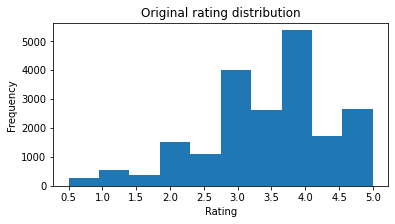

In [90]:
plt.figure(figsize=(6,3))
plt.title('Original rating distribution')
plt.xlabel('Rating')
plt.xticks(np.arange(0, 6, 0.5))
df_predictions.rating.plot.hist(bins=10)

<AxesSubplot:title={'center':'GNN rating distribution'}, xlabel='Rating', ylabel='Frequency'>

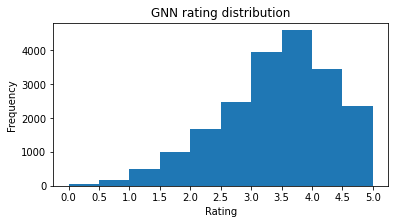

In [89]:
plt.figure(figsize=(6,3))
plt.title('GNN rating distribution')
plt.xlabel('Rating')
plt.xticks(np.arange(0, 6, 0.5))
df_predictions.prediction.plot.hist(bins=10)

<AxesSubplot:title={'center':'MSE Loss distribution'}, xlabel='mse', ylabel='Frequency'>

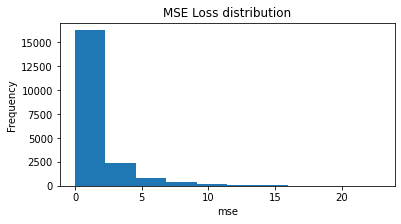

In [79]:
plt.figure(figsize=(6,3))
plt.title('MSE Loss distribution')
plt.xlabel('mse')
df_predictions.mse_loss.plot.hist()